## Fashion MNIST (Homework dataset)


The MNIST dataset is not too demanding, let's try something a little more difficult - Fashion MNIST.

[LINK TO IMAGE](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Check out labels on [GitHub](https://github.com/zalandoresearch/fashion-mnist):

# **HOMEWORK 1**
Build a classifier for fashion MNIST.

**1. Use exactly the same architectures (both densely connected layers and from convolutional layers) as the above MNIST** e.g., replace the dataset. Save the Jupyter Notebook in its original format and output a PDF file after training, testing, and validation. Make sure to write down how do they perform (training accuracny, testing accuracy).  
**2. Improve the architecture**. Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy!
Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image
#import torchvision.transforms as T

In [2]:
data = FashionMNIST(root="data/", download=True, train = True, transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=128,
                                          shuffle=True)
print(data)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [3]:
labels_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

torch.Size([1, 28, 28]) 0
tensor([[[0.6510, 0.5961, 0.6196, 0.6196, 0.6275],
         [0.6235, 0.6000, 0.6157, 0.6196, 0.6353],
         [0.6196, 0.6078, 0.6353, 0.6196, 0.6275],
         [0.5961, 0.6275, 0.6196, 0.6314, 0.6275],
         [0.5765, 0.6431, 0.6078, 0.6471, 0.6314]]])
tensor(1.) tensor(0.)


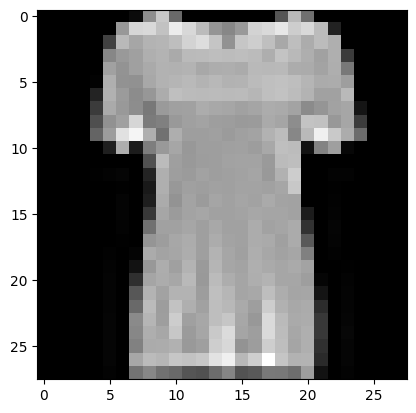

In [4]:
# mnist_dataset has 'images as tensors' so that they can't be displayed directly
sampleTensor, label = data[10]
print(sampleTensor.shape, label)
tpil = transforms.ToPILImage() # using the __call__ to
image = tpil(sampleTensor)
image.show()

print(sampleTensor[:,10:15,10:15])
print(torch.max(sampleTensor), torch.min(sampleTensor))
plt.imshow(sampleTensor[0,:,:],cmap = 'gray')

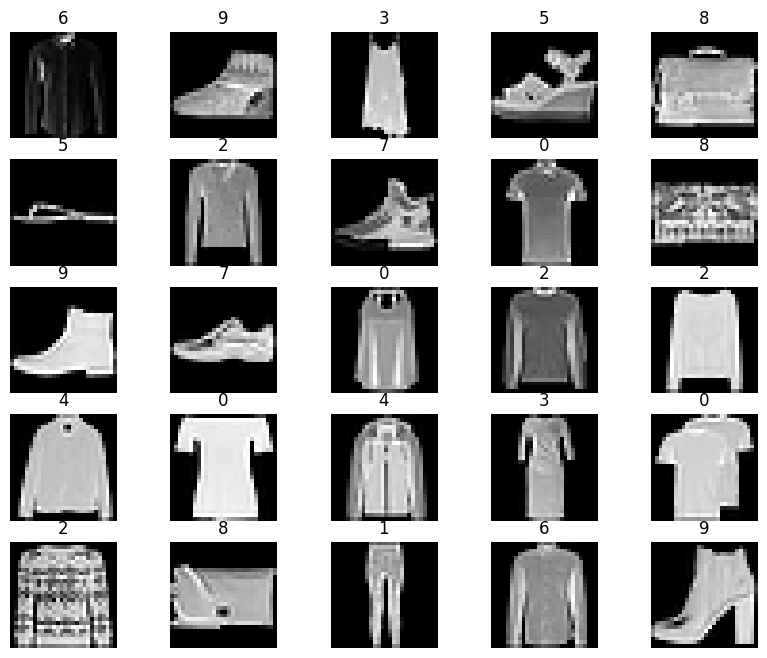

In [5]:
# Print multiple images at once
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Same architecture

## Training and validation data


In [6]:
train_data, validation_data = random_split(data, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)
## MNIST data from pytorch already provides held-out test set!

length of Train Datasets:  50000
length of Validation Datasets:  10000


## Multi-class Logistic Regression (a building block of DNN)

In [7]:
## Basic set up for a logistic regression model (won't be used in practice or for training)
input_size = 28 * 28
num_classes = 10

# we gradually build on this inherited class from pytorch
# model = nn.Linear(input_size, num_classes)

In [8]:
# Slowly build the model, first with basic
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        # view xb with two dimensions, 28 * 28(i.e 784)
        # One argument to .reshape can be set to -1(in this case the first dimension),
        # to let PyTorch figure it out automatically based on the shape of the original tensor.
        xb = xb.reshape(-1, 784)
        print(xb)
        out = self.linear(xb)
        print(out)
        return(out)

model = MnistModel()
print(model)
list(model.parameters())

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


[Parameter containing:
 tensor([[ 0.0169,  0.0246, -0.0012,  ...,  0.0279, -0.0153,  0.0277],
         [-0.0205, -0.0274,  0.0277,  ...,  0.0037, -0.0349,  0.0141],
         [-0.0039, -0.0347,  0.0204,  ..., -0.0117,  0.0237, -0.0054],
         ...,
         [ 0.0015,  0.0166,  0.0246,  ...,  0.0302, -0.0279, -0.0190],
         [-0.0027,  0.0070,  0.0087,  ...,  0.0178, -0.0053, -0.0102],
         [ 0.0034, -0.0027,  0.0241,  ...,  0.0019,  0.0029, -0.0075]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0327, -0.0137, -0.0026, -0.0227, -0.0261, -0.0033,  0.0325,  0.0036,
         -0.0171,  0.0103], requires_grad=True)]

In [9]:
# Alway check the dimensions and sample data/image
for images, labels in train_loader:
    outputs = model(images)
    break

print('Outputs shape: ', outputs.shape) # torch.Size([128, 10])
print('Sample outputs: \n', outputs[:2].data) # example outputs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[-0.0230, -0.1354, -0.3213,  ..., -0.0576, -0.0507, -0.0140],
        [ 0.0815,  0.4139, -0.1588,  ..., -0.4338,  0.0424,  0.3543],
        [ 0.3251,  0.3702, -0.0294,  ..., -0.5192, -0.0930,  0.5795],
        ...,
        [ 0.2566,  0.4351, -0.0308,  ..., -0.3130, -0.0233,  0.3533],
        [ 0.3122,  0.2628, -0.0397,  ..., -0.4359, -0.0640,  0.5627],
        [ 0.1528,  0.2177,  0.0875,  ..., -0.3824, -0.1661,  0.4313]],
       grad_fn=<AddmmBackward0>)
Outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[-0.0230, -0.1354, -0.3213, -0.1971, -0.1424, -0.2124, -0.0789, -0.0576,
         -0.0507, -0.0140],
        [ 0.0815,  0.4139, -0.1588, -0.5258, -0.0114, -0.4722,  0.0043, -0.4338,
          0.0424,  0.3543]])


##Softmax function

In [10]:
## Apply softmax for each output row
probs = F.softmax(outputs, dim = 1)

## chaecking at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

Sample probabilities:
 tensor([[0.1101, 0.0984, 0.0817, 0.0925, 0.0977, 0.0911, 0.1041, 0.1063, 0.1071,
         0.1111],
        [0.1110, 0.1548, 0.0873, 0.0605, 0.1011, 0.0638, 0.1027, 0.0663, 0.1067,
         0.1458]])


## Evaluation Metric and Loss Function


In [11]:
# accuracy calculation
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

print("Accuracy: ", accuracy(outputs, labels))
print("\n")
loss_fn = F.cross_entropy
print("Loss Function: ",loss_fn)
print("\n")
## Loss for the current batch
loss = loss_fn(outputs, labels)
print(loss)

Accuracy:  tensor(0.0938)


Loss Function:  <function cross_entropy at 0x7dc948151bc0>


tensor(2.3265, grad_fn=<NllLossBackward0>)


## Cross-Entropy

In [12]:
# We put all of the above:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    # We add extra methods
    def training_step(self, batch):
        # when training, we compute the cross entropy, which help us update weights
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        # in validation, we want to also look at the accuracy
        # idealy, we would like to save the model when the accuracy is the highest.
        acc = accuracy(out, labels) ## calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# a simple helper function to evaluate
def evaluate(model, data_loader):
    # for batch in data_loader, run validation_step
    outputs = [model.validation_step(batch) for batch in data_loader]
    return(model.validation_epoch_end(outputs))

# actually training
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [14]:
# test the functions, with a randomly initialized model (weights are random, e.g., untrained)
model = MnistModel()
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3322653770446777, 'val_acc': 0.10917721688747406}

In [15]:
# let's train for 10 epochs
history1 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6982, val_acc: 0.6304
Epoch [1], val_loss: 1.4095, val_acc: 0.6614
Epoch [2], val_loss: 1.2450, val_acc: 0.6695
Epoch [3], val_loss: 1.1395, val_acc: 0.6782
Epoch [4], val_loss: 1.0656, val_acc: 0.6830
Epoch [5], val_loss: 1.0111, val_acc: 0.6945
Epoch [6], val_loss: 0.9684, val_acc: 0.7024
Epoch [7], val_loss: 0.9340, val_acc: 0.7073
Epoch [8], val_loss: 0.9057, val_acc: 0.7166
Epoch [9], val_loss: 0.8816, val_acc: 0.7230


Text(0.5, 1.0, 'Accuracy over epochs')

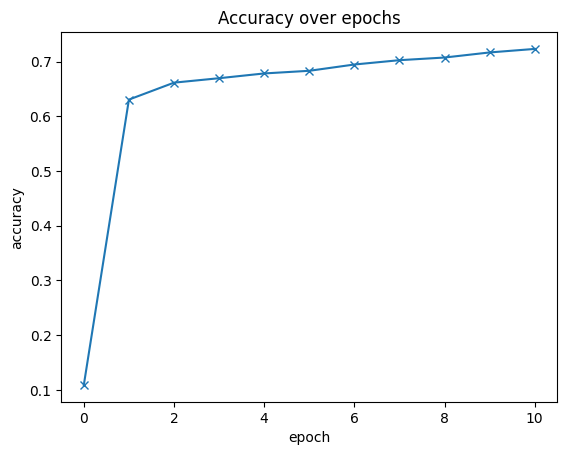

In [16]:
# we combine the first result (no training) and the training results of 5 epoches
# plotting accuracy
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

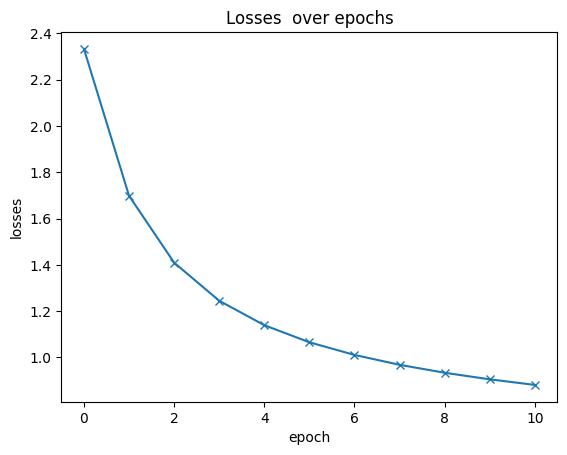

In [17]:
# plotting losses
history = [result0] + history1
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

## Final check using the (held-out) test dataset.

Length of Test Datasets:  10000
Shape:  torch.Size([1, 28, 28])
Label: Ankle boot (9)


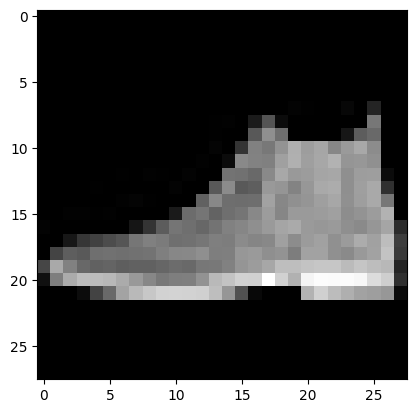

In [18]:
# Testing with individual images
## Define the test dataset
test_dataset = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())
print("Length of Test Datasets: ", len(test_dataset))
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("Shape: ", img.shape)
print(f'Label: {labels_dict[label]} ({label})')


In [19]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

img, label = test_dataset[0]
pred_label = predict_image(img, model)

print(f'Label: {labels_dict[label]} ({label}),  Predicted : {labels_dict[pred_label]} ({pred_label}) ')

Label: Ankle boot (9),  Predicted : Ankle boot (9) 


In [20]:
# the final check on the test dataset (not used in any training)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8951730728149414, 'val_acc': 0.707226574420929}

## CNN

In [21]:
# We construct a fundamental CNN class.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [22]:
loss_func = nn.CrossEntropyLoss()
loss_func

# unlike earlier example using optim.SGD, we use optim.Adam as the optimizer
# lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [23]:
# train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
# ## Print the length of train and validation datasets
# print("length of Train Datasets: ", len(train_data))
# print("length of Validation Datasets: ", len(validation_data))

# batch_size = 128
# train_loader = DataLoader(train_data, batch_size, shuffle = True)
# val_loader = DataLoader(validation_data, batch_size, shuffle = False)
from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

In [24]:
# instiate the CNN model
cnn = CNN()
# for testing purpose, we calculate the accuracy of the initial
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Accuracy of the model on the 10000 test images: 0.09


In [25]:
train(num_epochs=5, cnn=cnn, loaders=train_loader)

Epoch [1/5], Step [100/391], Loss: 0.6062
Epoch [1/5], Step [200/391], Loss: 0.3689
Epoch [1/5], Step [300/391], Loss: 0.3372
Epoch [2/5], Step [100/391], Loss: 0.4148
Epoch [2/5], Step [200/391], Loss: 0.2479
Epoch [2/5], Step [300/391], Loss: 0.3495
Epoch [3/5], Step [100/391], Loss: 0.2951
Epoch [3/5], Step [200/391], Loss: 0.2994
Epoch [3/5], Step [300/391], Loss: 0.2230
Epoch [4/5], Step [100/391], Loss: 0.3181
Epoch [4/5], Step [200/391], Loss: 0.3200
Epoch [4/5], Step [300/391], Loss: 0.2628
Epoch [5/5], Step [100/391], Loss: 0.2678
Epoch [5/5], Step [200/391], Loss: 0.2771
Epoch [5/5], Step [300/391], Loss: 0.2338


In [26]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.93


In [27]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.88


In [28]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number:     {actual_number}')

Prediction number: [9 2 1 1 6 1 4 6 5 7]
Actual number:     [9 2 1 1 6 1 4 6 5 7]
